In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import Dataset, DataLoader, TensorDataset
from copy import deepcopy
from sklearn import cluster
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
#Download data from https://github.com/udacity/P1_Facial_Keypoints

ROOT_DIR = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(ROOT_DIR, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')


In [3]:
data[:5]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [4]:
class FacesData(Dataset):
    """
    Dataset class for the facial keypoints dataset
    """
    def __init__(self, df):
        """
        Initialize the dataset
        Parameters:
        df (pandas.DataFrame): dataframe containing the image paths and keypoints
        """
        super(FacesData, self).__init__()
        self.df = df

        #Normalization
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])

    def __len__(self):
        """
        Return the length of the dataset
        """
        return len(self.df)

    def __getitem__(self, ix):
        """
        Return the item at index ix
        Parameters:
        ix (int): index of the item to return
        Returns:
        img (torch.Tensor): preprocessed image
        keypoints (torch.Tensor): keypoints of the image
        """
        img_path = ROOT_DIR + self.df.iloc[ix, 0]
        img = cv2.imread(img_path)/255
        kp = deepcopy(self.df.iloc[ix,1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2) 
        img = self.preprocess_input(img)
        return img, kp2

    def preprocess_input(self, img: np.ndarray) -> torch.Tensor:
        """
        Preprocess the input image

        Parameters:
        img (numpy.array): input image

        Returns:
        img (torch.Tensor): preprocessed image
        """
        # Resize the image to the required size
        img = cv2.resize(img, (224, 224))

        # Convert the image to a tensor and permute the dimensions to
        # (channels, height, width)
        img = torch.Tensor(img).permute(2, 0, 1)

        # Normalize the image using the mean and standard deviation for the
        # ImageNet dataset
        img = self.normalize(img).float()

        return img
    
    def load_img(self, ix):
        """
        Load the image at index ix
        Parameters:
            ix (int): index of the image to load
        Returns:
            img (numpy.array): loaded image
        """
        img_path = ROOT_DIR + self.df.iloc[ix, 0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224, 224))
        return img

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into a training set and a test set
# The training set will be used to train the model
# The test set will be used to evaluate the model
train, test = train_test_split(data, test_size=0.2, random_state=101)

train_data = FacesData(train)
test_data = FacesData(test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)



In [6]:
train_data[0][1].shape

torch.Size([136])

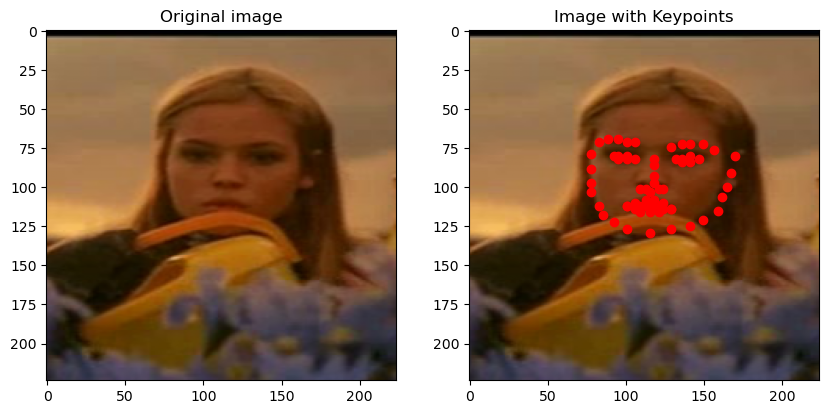

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = train_data.load_img(0)
plt.imshow(im)

plt.subplot(222)
plt.title('Image with Keypoints')
plt.imshow(im)
key_points = train_data[0][1].numpy() * 224
plt.scatter(key_points[0:68], key_points[68:], c='r')
plt.grid(False)
plt.show()


In [8]:
model = models.vgg16(pretrained=True)

c:\Users\LOQ\anaconda3\envs\pytorchenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LOQ\anaconda3\envs\pytorchenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model.avgpool

AdaptiveAvgPool2d(output_size=(7, 7))

In [10]:
from torch import sigmoid


def get_model():
    model = models.vgg16(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False # Freeze the parameters of the model
    
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.Flatten(),
    )  # Change the last layer

    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 136),
        nn.Sigmoid()
    ) # Changing the classifier layer to output 136 values for each keypoint

    loss_fn = nn.L1Loss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), loss_fn, optimizer


In [11]:
model, criterion, optimizer = get_model()

In [12]:
def train_batch(img, keypoints, model, optimizer, loss_fn):
    """
    Train the model on a single batch of data.

    Parameters:
        img (torch.Tensor): Input image tensor
        keypoints (torch.Tensor): Ground truth keypoints tensor
        model (torch.nn.Module): Model to be trained
        optimizer (torch.optim.Optimizer): Optimizer to update model parameters
        loss_fn (callable): Loss function to compute error

    Returns:
        loss (torch.Tensor): Loss value for the current batch
    """
    # Set the model to training mode
    model.train()
    
    # Clear the gradients of the optimizer
    optimizer.zero_grad()
    
    # Forward pass: predict keypoints using the model
    _keypoints = model(img.to(device))
    
    # Compute the loss between predicted and ground truth keypoints
    loss = loss_fn(_keypoints, keypoints.to(device))
    
    # Backward pass: compute gradients of the loss with respect to model parameters
    loss.backward()
    
    # Update model parameters using the optimizer
    optimizer.step()
    
    # Return the loss value for the current batch
    return loss

In [13]:
@torch.no_grad()
def validate_batch(img, keypoints, model, loss_fn):
    """
    Validate the model on a single batch of data.

    Parameters:
        img (torch.Tensor): Input image tensor
        keypoints (torch.Tensor): Ground truth keypoints tensor
        model (torch.nn.Module): Model to be validated
        loss_fn (callable): Loss function to compute error

    Returns:
        _keypoints (torch.Tensor): Predicted keypoints tensor
        loss (torch.Tensor): Loss value for the current batch
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Forward pass: predict keypoints using the model
    _keypoints = model(img.to(device))
    
    # Compute the loss between predicted and ground truth keypoints
    loss = loss_fn(_keypoints, keypoints.to(device))
    
    # Return the predicted keypoints and loss value for the current batch
    return _keypoints, loss

In [14]:
import time

# Initialize lists to store training and testing losses
train_loss, test_loss = [], []

# Define the number of epochs to train
N_EPOCHS = 50

# Train the model for N_EPOCHS
for epoch in range(N_EPOCHS):
    # Start the timer
    start = time.time()
    # Initialize variables to store epoch-wise training and testing losses
    epoch_train_loss, epoch_test_loss = 0, 0
    
    # Train the model on the training dataset
    for ix, (img, kps) in enumerate(train_loader):
        # Train the model on a single batch and compute the loss
        loss = train_batch(img, kps, model, optimizer, criterion)
        
        # Accumulate the loss for the epoch
        epoch_train_loss += loss.item()
    
    # Compute the average training loss for the epoch
    epoch_train_loss /= (ix+1)  # ix is the number of batches, add 1 to avoid division by zero
    
    # Validate the model on the testing dataset
    for ix, (img, kps) in enumerate(test_loader):
        # Validate the model on a single batch and compute the loss
        ps, loss = validate_batch(img, kps, model, criterion)
        
        # Accumulate the loss for the epoch
        epoch_test_loss += loss.item()
    
    # Compute the average testing loss for the epoch
    epoch_test_loss /= (ix+1)  # ix is the number of batches, add 1 to avoid division by zero
    
    # Print the epoch-wise training and testing losses
    end = time.time()
    print(f"Epoch {epoch+1} : 50", "| Train Loss: {:.4f}".format(epoch_train_loss),
         "Test Loss: {:.4f}".format(epoch_test_loss), end='')
    print(f"| Time Taken: {((end - start) / 60):.3f} min")
    
    # Append the epoch-wise training and testing losses to the lists
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

Epoch 1 : 50 | Train Loss: 0.0587 Test Loss: 0.0353| Time Taken: 0.418 min
Epoch 2 : 50 | Train Loss: 0.0415 Test Loss: 0.0280| Time Taken: 0.415 min
Epoch 3 : 50 | Train Loss: 0.0345 Test Loss: 0.0244| Time Taken: 0.411 min
Epoch 4 : 50 | Train Loss: 0.0305 Test Loss: 0.0242| Time Taken: 0.414 min
Epoch 5 : 50 | Train Loss: 0.0278 Test Loss: 0.0221| Time Taken: 0.419 min
Epoch 6 : 50 | Train Loss: 0.0262 Test Loss: 0.0219| Time Taken: 0.420 min
Epoch 7 : 50 | Train Loss: 0.0249 Test Loss: 0.0209| Time Taken: 0.421 min
Epoch 8 : 50 | Train Loss: 0.0238 Test Loss: 0.0204| Time Taken: 0.421 min
Epoch 9 : 50 | Train Loss: 0.0229 Test Loss: 0.0208| Time Taken: 0.420 min
Epoch 10 : 50 | Train Loss: 0.0221 Test Loss: 0.0200| Time Taken: 0.421 min
Epoch 11 : 50 | Train Loss: 0.0215 Test Loss: 0.0198| Time Taken: 0.422 min
Epoch 12 : 50 | Train Loss: 0.0209 Test Loss: 0.0203| Time Taken: 0.419 min
Epoch 13 : 50 | Train Loss: 0.0207 Test Loss: 0.0201| Time Taken: 0.419 min
Epoch 14 : 50 | Train

In [15]:
torch.save(model, 'facial_keypoint_model.pth')

In [16]:
model = torch.load('facial_keypoint_model.pth')

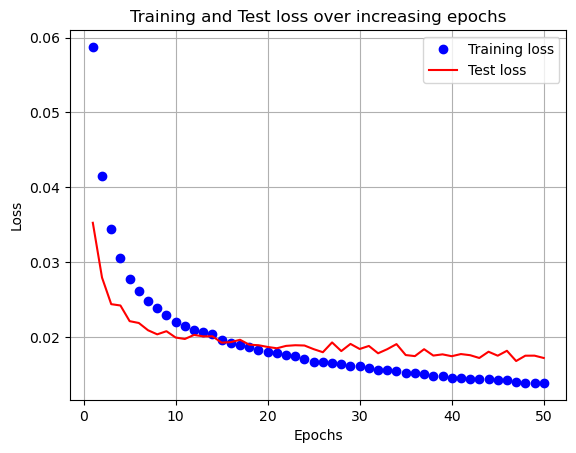

In [17]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.savefig('loss_plot.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

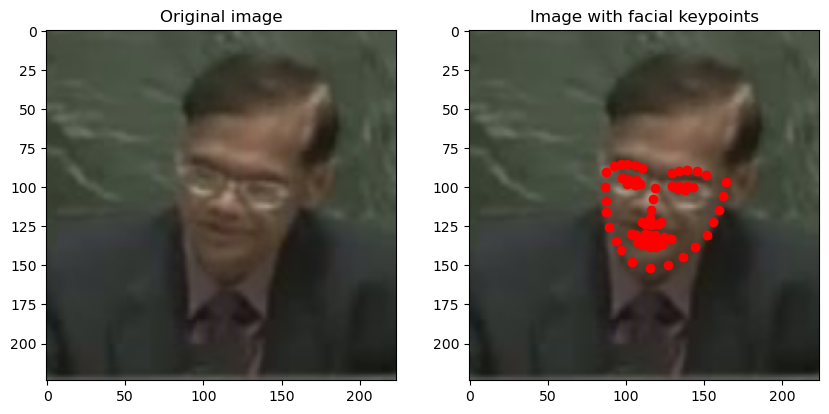

In [18]:
from random import randint

index = randint(0, len(test_data))
output = model(test_data[index][0].unsqueeze(0).to(device))
kp = output.to('cpu').detach().numpy()[0]
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_data.load_img(index)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
plt.imshow(im)
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()
